In [1]:
################################################################################
# CELL 1: ENVIRONMENT SETUP AND VERIFICATION
################################################################################

import os
import sys

print("="*80)
print("RESPIRATORY DISEASE CLASSIFICATION - AST TWO-MODEL PIPELINE")
print("="*80)

# Check if running on Kaggle
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("✓ Running in KAGGLE NOTEBOOK")
else:
    print("⚠️  Not running in Kaggle environment")

# Check GPU availability
import torch
print(f"\n✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Verify dataset paths
print("\n" + "="*80)
print("CHECKING KAGGLE MOUNTED DATASETS")
print("="*80)

datasets = {
    'ICBHI_2017': '/kaggle/input/respiratory-sound-database',
    'KAUST': '/kaggle/input/lung-dataset',
    'SPRSound': '/kaggle/input/sprsound-lung-audio-dataset'
}

for name, path in datasets.items():
    if os.path.exists(path):
        file_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        print(f"✓ {name}: FOUND at {path.split('/')[-1]} ({file_count} files)")
    else:
        print(f"❌ {name}: NOT FOUND")

print("\n✓ Environment setup complete!")


RESPIRATORY DISEASE CLASSIFICATION - AST TWO-MODEL PIPELINE
✓ Running in KAGGLE NOTEBOOK

✓ PyTorch version: 2.6.0+cu124
✓ CUDA available: True
✓ GPU Device: Tesla P100-PCIE-16GB
✓ GPU Memory: 17.06 GB

CHECKING KAGGLE MOUNTED DATASETS
✓ ICBHI_2017: FOUND at respiratory-sound-database (1 files)
✓ KAUST: FOUND at lung-dataset (1 files)
✓ SPRSound: FOUND at sprsound-lung-audio-dataset (0 files)

✓ Environment setup complete!


In [2]:
################################################################################
# CELL 2: INSTALL REQUIRED LIBRARIES (CORRECTED)
################################################################################

print("Installing required libraries...")

# Install audio processing libraries
!pip install librosa==0.10.1 -q
!pip install soundfile -q
!pip install noisereduce -q

# Install ML/DL libraries
!pip install timm -q  # For transformer models
!pip install scikit-learn -q

# Use torch-audiomentations instead of audiomentations (better for PyTorch)
!pip install torch-audiomentations -q

print("✓ All libraries installed successfully!")

# Import all necessary libraries
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import noisereduce as nr

# Use torch-audiomentations for GPU-accelerated augmentation
try:
    from torch_audiomentations import Compose, Gain, PolarityInversion, AddBackgroundNoise
    print("✓ Using torch-audiomentations for augmentation")
except ImportError:
    print("⚠️  torch-audiomentations not available, will use librosa for augmentation")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
import sys

print("✓ All imports successful!")
print(f"✓ Using librosa version: {librosa.__version__}")
print(f"✓ Using PyTorch version: {torch.__version__}")


Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✓ All imports successful!
✓ Using librosa version: 0.10.1
✓ Using PyTorch version: 2.6.0+cu124


In [3]:
################################################################################
# CELL 3: COMPREHENSIVE DATA LOADING (FIXED - RECURSIVE SEARCH)
################################################################################

import os
import pandas as pd
import numpy as np
import re

print("="*80)
print("STEP 1: DATA LOADING AND LABEL EXTRACTION")
print("="*80)

# Dataset paths
ICBHI_PATH = '/kaggle/input/respiratory-sound-database'
KAUST_PATH = '/kaggle/input/lung-dataset'
SPRSOUND_PATH = '/kaggle/input/sprsound-lung-audio-dataset'

################################################################################
# Function 1: Load ICBHI Dataset (RECURSIVE SEARCH)
################################################################################

def load_icbhi_data():
    """
    Load ICBHI 2017 dataset with recursive directory search.
    Expected: ~1,840 files
    """
    print("\n" + "="*60)
    print("Loading ICBHI Dataset...")
    print("="*60)
    
    # Find all WAV files recursively
    wav_files = []
    for root, dirs, files in os.walk(ICBHI_PATH):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    
    print(f"   Found {len(wav_files)} WAV files")
    
    # Find patient diagnosis CSV recursively
    diagnosis_df = None
    for root, dirs, files in os.walk(ICBHI_PATH):
        for file in files:
            if file.endswith('.csv') and 'diagnosis' in file.lower():
                try:
                    csv_path = os.path.join(root, file)
                    df = pd.read_csv(csv_path)
                    if len(df.columns) >= 2:
                        diagnosis_df = df
                        diagnosis_df.columns = ['patient_id', 'disease']
                        print(f"   Loaded diagnosis from: {file}")
                        break
                except Exception as e:
                    continue
        if diagnosis_df is not None:
            break
    
    data_records = []
    
    for wav_path in wav_files:
        try:
            audio_file = os.path.basename(wav_path)
            
            # Extract patient ID from filename
            parts = audio_file.split('_')
            patient_id = int(parts[0])
            
            # Find corresponding annotation file
            annotation_file = audio_file.replace('.wav', '.txt')
            annotation_path = wav_path.replace('.wav', '.txt')
            
            sound_label = 'Normal'
            
            if os.path.exists(annotation_path):
                try:
                    annotations = pd.read_csv(annotation_path, sep='\t', 
                                             names=['start', 'end', 'crackles', 'wheezes'],
                                             header=None)
                    
                    has_crackles = annotations['crackles'].sum() > 0
                    has_wheezes = annotations['wheezes'].sum() > 0
                    
                    if has_crackles and has_wheezes:
                        sound_label = 'Both'
                    elif has_crackles:
                        sound_label = 'Crackle'
                    elif has_wheezes:
                        sound_label = 'Wheeze'
                    else:
                        sound_label = 'Normal'
                except Exception:
                    sound_label = 'Normal'
            
            # Get disease label
            disease_label = 'Unknown'
            if diagnosis_df is not None:
                try:
                    disease_row = diagnosis_df[diagnosis_df['patient_id'] == patient_id]
                    if len(disease_row) > 0:
                        disease_label = str(disease_row['disease'].values[0])
                except Exception:
                    disease_label = 'Unknown'
            
            data_records.append({
                'file_path': wav_path,
                'filename': audio_file,
                'patient_id': patient_id,
                'sound_label': sound_label,
                'disease_label': disease_label,
                'dataset': 'ICBHI'
            })
        except Exception as e:
            continue
    
    icbhi_df = pd.DataFrame(data_records)
    
    print(f"   Successfully loaded {len(icbhi_df)} files")
    if len(icbhi_df) > 0:
        print(f"\n   Sound Labels:")
        print(icbhi_df['sound_label'].value_counts().to_string().replace('\n', '\n      '))
        print(f"\n   Disease Labels (Top 5):")
        print(icbhi_df['disease_label'].value_counts().head().to_string().replace('\n', '\n      '))
    
    return icbhi_df

################################################################################
# Function 2: Load KAUST Dataset (RECURSIVE SEARCH)
################################################################################

def load_kaust_data():
    """
    Load KAUST dataset with recursive directory search.
    Expected: ~336 files
    """
    print("\n" + "="*60)
    print("Loading KAUST Dataset...")
    print("="*60)
    
    # Find all WAV files recursively
    wav_files = []
    for root, dirs, files in os.walk(KAUST_PATH):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    
    print(f"   Found {len(wav_files)} WAV files")
    
    data_records = []
    
    for wav_path in wav_files:
        try:
            audio_file = os.path.basename(wav_path)
            
            # Parse filename: "EP76_N,N,A L U,31,M.wav"
            parts = audio_file.replace('.wav', '').split('_')
            patient_id = parts[0]
            
            sound_label = 'Normal'
            disease_label = 'Normal'
            
            if len(parts) > 1:
                metadata_str = parts[1]
                metadata = metadata_str.split(',')
                
                if len(metadata) > 0:
                    disease_raw = metadata[0].strip()
                    disease_label = disease_raw if disease_raw != 'N' else 'Normal'
                
                if len(metadata) > 1:
                    sound_raw = metadata[1].strip()
                    if 'Crep' in sound_raw or 'C' in sound_raw:
                        sound_label = 'Crackle'
                    elif 'W' in sound_raw or 'w' in sound_raw:
                        sound_label = 'Wheeze'
                    elif 'E' in sound_raw:
                        sound_label = 'Wheeze'
                    else:
                        sound_label = 'Normal'
            
            data_records.append({
                'file_path': wav_path,
                'filename': audio_file,
                'patient_id': patient_id,
                'sound_label': sound_label,
                'disease_label': disease_label,
                'dataset': 'KAUST'
            })
        except Exception as e:
            continue
    
    kaust_df = pd.DataFrame(data_records)
    
    print(f"   Successfully loaded {len(kaust_df)} files")
    if len(kaust_df) > 0:
        print(f"\n   Sound Labels:")
        print(kaust_df['sound_label'].value_counts().to_string().replace('\n', '\n      '))
        print(f"\n   Disease Labels (Top 5):")
        print(kaust_df['disease_label'].value_counts().head().to_string().replace('\n', '\n      '))
    
    return kaust_df

################################################################################
# Function 3: Load SPRSound Dataset (RECURSIVE SEARCH - FIXED)
################################################################################

def load_sprsound_data():
    """
    Load SPRSound dataset with recursive directory search.
    Expected: ~13,940 files
    """
    print("\n" + "="*60)
    print("Loading SPRSound Dataset...")
    print("="*60)
    
    # Find all CSV files recursively
    csv_files = []
    for root, dirs, files in os.walk(SPRSOUND_PATH):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    print(f"   Found {len(csv_files)} CSV files")
    
    # Load patient summary CSVs
    all_patient_data = []
    for csv_path in csv_files:
        try:
            df = pd.read_csv(csv_path)
            
            # Check if it has patient_num column
            if 'patient_num' in df.columns and 'disease' in df.columns:
                all_patient_data.append(df)
                print(f"      Loaded: {os.path.basename(csv_path)}")
        except Exception as e:
            continue
    
    patient_df = None
    if all_patient_data:
        patient_df = pd.concat(all_patient_data, ignore_index=True)
        print(f"   Combined patient data: {len(patient_df)} records")
    
    # Find all WAV files recursively
    wav_files = []
    for root, dirs, files in os.walk(SPRSOUND_PATH):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    
    print(f"   Found {len(wav_files)} WAV files")
    
    data_records = []
    
    for wav_path in wav_files:
        try:
            audio_file = os.path.basename(wav_path)
            
            # Extract patient number from filename using regex
            # Common patterns: "14365_1_1_1_Tc.wav" or similar
            numbers = re.findall(r'\d+', audio_file)
            
            if numbers and len(numbers) > 0:
                # First number is usually patient ID
                patient_num = int(numbers[0])
                
                disease_label = 'Unknown'
                
                # Match with patient summary
                if patient_df is not None:
                    patient_info = patient_df[patient_df['patient_num'] == patient_num]
                    
                    if len(patient_info) > 0:
                        disease = str(patient_info.iloc[0]['disease'])
                        
                        # Map to standard labels
                        if 'Control' in disease or 'Normal' in disease or 'control' in disease:
                            disease_label = 'Normal'
                        elif 'Pneumonia' in disease or 'pneumonia' in disease:
                            disease_label = 'Pneumonia'
                        elif 'Bronchitis' in disease or 'bronchitis' in disease:
                            disease_label = 'Bronchitis'
                        elif 'Asthma' in disease or 'asthma' in disease:
                            disease_label = 'Asthma'
                        else:
                            disease_label = disease
                
                data_records.append({
                    'file_path': wav_path,
                    'filename': audio_file,
                    'patient_id': patient_num,
                    'sound_label': 'Unknown',  # Will determine during preprocessing
                    'disease_label': disease_label,
                    'dataset': 'SPRSound'
                })
        except Exception as e:
            continue
    
    sprsound_df = pd.DataFrame(data_records)
    
    print(f"   Successfully loaded {len(sprsound_df)} files")
    if len(sprsound_df) > 0:
        print(f"\n   Disease Labels (Top 5):")
        print(sprsound_df['disease_label'].value_counts().head().to_string().replace('\n', '\n      '))
    
    return sprsound_df

################################################################################
# EXECUTE: Load All Datasets
################################################################################

print("\n" + "="*80)
print("LOADING ALL DATASETS...")
print("="*80)

# Load datasets with error handling
try:
    icbhi_df = load_icbhi_data()
except Exception as e:
    print(f"ERROR loading ICBHI: {e}")
    icbhi_df = pd.DataFrame()

try:
    kaust_df = load_kaust_data()
except Exception as e:
    print(f"ERROR loading KAUST: {e}")
    kaust_df = pd.DataFrame()

try:
    sprsound_df = load_sprsound_data()
except Exception as e:
    print(f"ERROR loading SPRSound: {e}")
    sprsound_df = pd.DataFrame()

# Combine all datasets
dataset_df = pd.concat([icbhi_df, kaust_df, sprsound_df], ignore_index=True)

################################################################################
# Standardize Labels for Both Models
################################################################################

print("\n" + "="*80)
print("STANDARDIZING LABELS...")
print("="*80)

# Disease label mapping for Model B (5 classes)
disease_mapping = {
    'Healthy': 'Normal',
    'Control Group': 'Normal',
    'Control group': 'Normal',
    'Normal': 'Normal',
    'COPD': 'COPD',
    'Asthma': 'Asthma',
    'asthma': 'Asthma',
    'Pneumonia': 'Pneumonia',
    'pneumonia': 'Pneumonia',
    'Bronchitis': 'Bronchitis',
    'bronchitis': 'Bronchitis',
    'URTI': 'Bronchitis',
    'Bronchiectasis': 'Bronchitis',
    'LRTI': 'Pneumonia',
    'heart failure': 'Other',
    'Heart Failure': 'Other',
    'Lung Fibrosis': 'Other',
    'lung fibrosis': 'Other'
}

dataset_df['disease_clean'] = dataset_df['disease_label'].apply(
    lambda x: disease_mapping.get(str(x), 'Other')
)

# Filter to only our 5 target disease classes for Model B
model_b_classes = ['Normal', 'COPD', 'Asthma', 'Pneumonia', 'Bronchitis']
dataset_df_filtered = dataset_df[dataset_df['disease_clean'].isin(model_b_classes)].copy()

print("\n" + "="*80)
print("DATA LOADING COMPLETE!")
print("="*80)
print(f"\nTotal files loaded: {len(dataset_df):,}")
print(f"Files for training (5 disease classes): {len(dataset_df_filtered):,}")

print(f"\nDataset Distribution:")
print(f"   ICBHI:    {len(icbhi_df):,} files")
print(f"   KAUST:    {len(kaust_df):,} files")
print(f"   SPRSound: {len(sprsound_df):,} files")

if len(dataset_df_filtered) > 0:
    print(f"\nSound Labels (Model A - 4 classes):")
    print(dataset_df_filtered['sound_label'].value_counts().to_string().replace('\n', '\n   '))
    
    print(f"\nDisease Labels (Model B - 5 classes):")
    print(dataset_df_filtered['disease_clean'].value_counts().to_string().replace('\n', '\n   '))
    
    # Save metadata
    dataset_df_filtered.to_csv('dataset_metadata.csv', index=False)
    print(f"\nSaved metadata to: dataset_metadata.csv")
    
    print(f"\nSample Data:")
    print(dataset_df_filtered[['filename', 'sound_label', 'disease_clean', 'dataset']].head(10))
else:
    print("\nWARNING: No data loaded successfully!")

print("\n" + "="*80)
print("READY FOR STEP 2: PREPROCESSING")
print("="*80)


STEP 1: DATA LOADING AND LABEL EXTRACTION

LOADING ALL DATASETS...

Loading ICBHI Dataset...
   Found 1840 WAV files
   Loaded diagnosis from: patient_diagnosis.csv
   Successfully loaded 1840 files

   Sound Labels:
sound_label
      Crackle    594
      Normal     574
      Both       404
      Wheeze     268

   Disease Labels (Top 5):
disease_label
      COPD              1586
      Pneumonia           74
      Healthy             70
      URTI                42
      Bronchiectasis      32

Loading KAUST Dataset...
   Found 336 WAV files
   Successfully loaded 336 files

   Sound Labels:
sound_label
      Wheeze     123
      Normal     108
      Crackle    105

   Disease Labels (Top 5):
disease_label
      Normal           105
      Asthma            51
      asthma            45
      heart failure     45
      COPD              24

Loading SPRSound Dataset...
   Found 3 CSV files
      Loaded: Grand_Challenge_24_patient_summary.csv
      Loaded: Grand_Challenge_23_patient_summ

In [4]:
################################################################################
# CELL 4: AUDIO PREPROCESSING AND SPECTROGRAM GENERATION
# Target: 16kHz resampling, noise reduction, 128-bin mel-spectrograms
################################################################################

import librosa
import librosa.display
import soundfile as sf
import noisereduce as nr
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STEP 2: AUDIO PREPROCESSING AND FEATURE EXTRACTION")
print("="*80)

################################################################################
# Configuration
################################################################################

SAMPLE_RATE = 16000  # Target sampling rate (16kHz)
SEGMENT_LENGTH = 5   # 5-second segments
N_MELS = 128        # Number of mel-frequency bins
N_FFT = 1024        # FFT window size
HOP_LENGTH = 512    # Hop length for STFT

print(f"\nPreprocessing Configuration:")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  Segment Length: {SEGMENT_LENGTH} seconds")
print(f"  Mel Bins: {N_MELS}")
print(f"  FFT Size: {N_FFT}")
print(f"  Hop Length: {HOP_LENGTH}")

################################################################################
# Audio Processing Functions
################################################################################

def load_and_preprocess_audio(file_path, target_sr=16000):
    """
    Load audio file and apply preprocessing.
    Returns: preprocessed audio array and sample rate
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)
        
        # Resample to target sample rate
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        
        # Apply noise reduction
        audio_denoised = nr.reduce_noise(y=audio, sr=sr)
        
        # Normalize amplitude to [-1, 1]
        if np.max(np.abs(audio_denoised)) > 0:
            audio_normalized = audio_denoised / np.max(np.abs(audio_denoised))
        else:
            audio_normalized = audio_denoised
        
        return audio_normalized, sr
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

def segment_audio(audio, sr, segment_length=5):
    """
    Segment audio into fixed-length chunks.
    Returns: list of audio segments
    """
    segment_samples = segment_length * sr
    segments = []
    
    # If audio is shorter than segment length, pad it
    if len(audio) < segment_samples:
        padded = np.pad(audio, (0, segment_samples - len(audio)), mode='constant')
        segments.append(padded)
    else:
        # Split into segments
        num_segments = len(audio) // segment_samples
        for i in range(num_segments):
            start = i * segment_samples
            end = start + segment_samples
            segments.append(audio[start:end])
        
        # Handle remaining audio
        remainder = len(audio) % segment_samples
        if remainder > 0:
            last_segment = audio[-segment_samples:]
            segments.append(last_segment)
    
    return segments

def audio_to_melspectrogram(audio, sr, n_mels=128, n_fft=1024, hop_length=512):
    """
    Convert audio to log-mel spectrogram.
    Returns: mel spectrogram array
    """
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=50,      # Minimum frequency for respiratory sounds
        fmax=2000     # Maximum frequency for respiratory sounds
    )
    
    # Convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

def detect_sound_type(mel_spec):
    """
    Detect sound type from mel spectrogram for 'Unknown' labels.
    Simple heuristic based on spectral characteristics.
    """
    # Calculate spectral statistics
    high_freq_energy = np.mean(mel_spec[64:, :])  # Upper half frequencies
    low_freq_energy = np.mean(mel_spec[:64, :])   # Lower half frequencies
    temporal_variance = np.var(mel_spec, axis=1).mean()
    
    # Simple classification heuristics
    if high_freq_energy > -40 and temporal_variance > 100:
        return 'Wheeze'  # High frequency continuous sound
    elif low_freq_energy > -30 and temporal_variance > 150:
        return 'Crackle'  # Low frequency discontinuous sound
    elif high_freq_energy > -35 and low_freq_energy > -35:
        return 'Both'  # Mixed sounds
    else:
        return 'Normal'  # Normal breathing

################################################################################
# Process Sample Files (Test Pipeline)
################################################################################

print("\n" + "="*80)
print("TESTING PREPROCESSING PIPELINE ON SAMPLE FILES")
print("="*80)

# Test on 5 sample files from each dataset
test_samples = dataset_df_filtered.groupby('dataset').head(2)

print(f"\nProcessing {len(test_samples)} test files...")

for idx, row in test_samples.iterrows():
    print(f"\n  File: {row['filename']}")
    print(f"  Dataset: {row['dataset']}")
    print(f"  Original Sound Label: {row['sound_label']}")
    
    # Load and preprocess
    audio, sr = load_and_preprocess_audio(row['file_path'], target_sr=SAMPLE_RATE)
    
    if audio is not None:
        print(f"  Audio Length: {len(audio)/sr:.2f} seconds")
        
        # Segment audio
        segments = segment_audio(audio, sr, segment_length=SEGMENT_LENGTH)
        print(f"  Number of Segments: {len(segments)}")
        
        # Generate spectrogram for first segment
        mel_spec = audio_to_melspectrogram(
            segments[0], sr, 
            n_mels=N_MELS, 
            n_fft=N_FFT, 
            hop_length=HOP_LENGTH
        )
        print(f"  Spectrogram Shape: {mel_spec.shape}")
        
        # Detect sound type if Unknown
        if row['sound_label'] == 'Unknown':
            detected_sound = detect_sound_type(mel_spec)
            print(f"  Detected Sound Type: {detected_sound}")

print("\n" + "="*80)
print("PREPROCESSING PIPELINE TEST COMPLETE")
print("="*80)

################################################################################
# Full Dataset Preprocessing Function
################################################################################

def preprocess_full_dataset(df, save_path='preprocessed_data.npz'):
    """
    Preprocess entire dataset and save spectrograms.
    This will take significant time for 14,416 files.
    """
    print("\n" + "="*80)
    print("PREPROCESSING FULL DATASET")
    print("="*80)
    print(f"Total files to process: {len(df)}")
    print("This will take approximately 30-60 minutes...")
    
    all_spectrograms = []
    all_sound_labels = []
    all_disease_labels = []
    all_filenames = []
    failed_files = 0
    
    # Process with progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        try:
            # Load and preprocess audio
            audio, sr = load_and_preprocess_audio(row['file_path'], target_sr=SAMPLE_RATE)
            
            if audio is None:
                failed_files += 1
                continue
            
            # Segment audio
            segments = segment_audio(audio, sr, segment_length=SEGMENT_LENGTH)
            
            # Process first segment only (can modify to use all segments)
            segment = segments[0]
            
            # Generate mel spectrogram
            mel_spec = audio_to_melspectrogram(
                segment, sr,
                n_mels=N_MELS,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )
            
            # Detect sound type if Unknown
            sound_label = row['sound_label']
            if sound_label == 'Unknown':
                sound_label = detect_sound_type(mel_spec)
            
            # Store data
            all_spectrograms.append(mel_spec)
            all_sound_labels.append(sound_label)
            all_disease_labels.append(row['disease_clean'])
            all_filenames.append(row['filename'])
            
        except Exception as e:
            failed_files += 1
            continue
    
    # Convert to numpy arrays
    spectrograms = np.array(all_spectrograms)
    
    print(f"\n  Successfully processed: {len(all_spectrograms)} files")
    print(f"  Failed: {failed_files} files")
    print(f"  Spectrogram array shape: {spectrograms.shape}")
    
    # Save preprocessed data
    np.savez_compressed(
        save_path,
        spectrograms=spectrograms,
        sound_labels=np.array(all_sound_labels),
        disease_labels=np.array(all_disease_labels),
        filenames=np.array(all_filenames)
    )
    
    print(f"\n  Saved preprocessed data to: {save_path}")
    
    return spectrograms, all_sound_labels, all_disease_labels, all_filenames

################################################################################
# User Choice: Process Now or Skip
################################################################################

print("\n" + "="*80)
print("READY TO PREPROCESS FULL DATASET")
print("="*80)
print("\nOptions:")
print("1. Run full preprocessing now (30-60 minutes)")
print("2. Continue with test data for model development")
print("\nTo run full preprocessing, execute:")
print("  spectrograms, sound_labels, disease_labels, filenames = preprocess_full_dataset(dataset_df_filtered)")

print("\n" + "="*80)
print("STEP 2 COMPLETE - READY FOR STEP 3: DATA AUGMENTATION")
print("="*80)


STEP 2: AUDIO PREPROCESSING AND FEATURE EXTRACTION

Preprocessing Configuration:
  Sample Rate: 16000 Hz
  Segment Length: 5 seconds
  Mel Bins: 128
  FFT Size: 1024
  Hop Length: 512

TESTING PREPROCESSING PIPELINE ON SAMPLE FILES

Processing 6 test files...

  File: 162_1b2_Ar_mc_AKGC417L.wav
  Dataset: ICBHI
  Original Sound Label: Both
  Audio Length: 20.00 seconds
  Number of Segments: 4
  Spectrogram Shape: (128, 157)

  File: 193_1b2_Pl_mc_AKGC417L.wav
  Dataset: ICBHI
  Original Sound Label: Wheeze
  Audio Length: 20.00 seconds
  Number of Segments: 4
  Spectrogram Shape: (128, 157)

  File: EP76_N,N,A L U,31,M.wav
  Dataset: KAUST
  Original Sound Label: Normal
  Audio Length: 14.58 seconds
  Number of Segments: 3
  Spectrogram Shape: (128, 157)

  File: EP93_N,N,P R M,75,M.wav
  Dataset: KAUST
  Original Sound Label: Normal
  Audio Length: 9.84 seconds
  Number of Segments: 2
  Spectrogram Shape: (128, 157)

  File: 41092032_7.2_1_p2_5692.wav
  Dataset: SPRSound
  Original So

In [5]:
################################################################################
# CELL 5: RUN FULL DATASET PREPROCESSING
# Processing 14,416 files - Estimated time: 30-60 minutes
################################################################################

import time

print("="*80)
print("STARTING FULL DATASET PREPROCESSING")
print("="*80)
print(f"Total files to process: {len(dataset_df_filtered):,}")
print(f"Estimated time: 30-60 minutes")
print("\nProcessing steps:")
print("  1. Load and denoise all audio files")
print("  2. Resample to 16kHz")
print("  3. Segment into 5-second clips")
print("  4. Generate 128-bin mel-spectrograms")
print("  5. Detect sound types for SPRSound 'Unknown' labels")
print("\n" + "="*80)

# Record start time
start_time = time.time()

# Run full preprocessing
spectrograms, sound_labels, disease_labels, filenames = preprocess_full_dataset(
    dataset_df_filtered, 
    save_path='preprocessed_data.npz'
)

# Calculate processing time
end_time = time.time()
processing_time = (end_time - start_time) / 60

print("\n" + "="*80)
print("PREPROCESSING COMPLETE!")
print("="*80)
print(f"\nProcessing time: {processing_time:.2f} minutes")

# Display final statistics
print(f"\nFinal Dataset Statistics:")
print(f"  Total spectrograms: {len(spectrograms):,}")
print(f"  Spectrogram shape: {spectrograms[0].shape}")
print(f"  Data type: {spectrograms.dtype}")
print(f"  Memory size: {spectrograms.nbytes / (1024**3):.2f} GB")

print(f"\n" + "="*60)
print("Sound Label Distribution (Model A):")
print("="*60)
sound_label_counts = pd.Series(sound_labels).value_counts()
for label, count in sound_label_counts.items():
    percentage = (count / len(sound_labels)) * 100
    print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")

print(f"\n" + "="*60)
print("Disease Label Distribution (Model B):")
print("="*60)
disease_label_counts = pd.Series(disease_labels).value_counts()
for label, count in disease_label_counts.items():
    percentage = (count / len(disease_labels)) * 100
    print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")

# Save summary statistics
summary_df = pd.DataFrame({
    'total_files': [len(spectrograms)],
    'spectrogram_shape': [str(spectrograms[0].shape)],
    'processing_time_minutes': [processing_time],
    'sound_classes': [len(sound_label_counts)],
    'disease_classes': [len(disease_label_counts)]
})
summary_df.to_csv('preprocessing_summary.csv', index=False)
print("\nSaved preprocessing summary to: preprocessing_summary.csv")

print("\n" + "="*80)
print("READY FOR STEP 3: DATA AUGMENTATION AND MODEL TRAINING")
print("="*80)


STARTING FULL DATASET PREPROCESSING
Total files to process: 14,416
Estimated time: 30-60 minutes

Processing steps:
  1. Load and denoise all audio files
  2. Resample to 16kHz
  3. Segment into 5-second clips
  4. Generate 128-bin mel-spectrograms
  5. Detect sound types for SPRSound 'Unknown' labels


PREPROCESSING FULL DATASET
Total files to process: 14416
This will take approximately 30-60 minutes...


Processing: 100%|██████████| 14416/14416 [34:55<00:00,  6.88it/s] 



  Successfully processed: 14416 files
  Failed: 0 files
  Spectrogram array shape: (14416, 128, 157)

  Saved preprocessed data to: preprocessed_data.npz

PREPROCESSING COMPLETE!

Processing time: 35.22 minutes

Final Dataset Statistics:
  Total spectrograms: 14,416
  Spectrogram shape: (128, 157)
  Data type: float32
  Memory size: 1.08 GB

Sound Label Distribution (Model A):
  Normal      : 13042 (90.47%)
  Crackle     :   600 ( 4.16%)
  Both        :   396 ( 2.75%)
  Wheeze      :   378 ( 2.62%)

Disease Label Distribution (Model B):
  Pneumonia   :  8750 (60.70%)
  COPD        :  1610 (11.17%)
  Normal      :  1411 ( 9.79%)
  Bronchitis  :  1386 ( 9.61%)
  Asthma      :  1259 ( 8.73%)

Saved preprocessing summary to: preprocessing_summary.csv

READY FOR STEP 3: DATA AUGMENTATION AND MODEL TRAINING


In [6]:
import numpy as np
from collections import Counter

# Fix for the oversampling function
def oversample_minority_classes(spectrograms, sound_labels, disease_labels, filenames, target_ratio=0.15):
    """
    Oversample minority classes to improve class balance
    
    Args:
        spectrograms: Array of mel-spectrograms
        sound_labels: Array of sound labels (Normal, Crackle, Wheeze, Both)
        disease_labels: Array or list of disease labels (can be multi-label)
        filenames: Array of filenames
        target_ratio: Target ratio for minority classes relative to majority class
    """
    
    # Convert disease_labels to consistent format (handle multi-label case)
    # If disease_labels are inconsistent, convert to strings or tuples
    disease_labels_str = []
    for label in disease_labels:
        if isinstance(label, (list, np.ndarray)):
            # Convert array/list to tuple for consistent hashing
            disease_labels_str.append(tuple(label) if len(label) > 0 else ('None',))
        else:
            disease_labels_str.append((label,))
    
    # Count class distribution
    sound_counter = Counter(sound_labels)
    print("\nOriginal Sound Label Distribution:")
    for label, count in sorted(sound_counter.items()):
        percentage = (count / len(sound_labels)) * 100
        print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")
    
    # Find majority class
    majority_class = max(sound_counter.items(), key=lambda x: x[1])[0]
    majority_count = sound_counter[majority_class]
    target_count = int(majority_count * target_ratio)
    
    print(f"\nApplying oversampling to minority classes...")
    
    # Separate data by class
    augmented_specs = []
    augmented_sounds = []
    augmented_diseases = []
    augmented_files = []
    
    for sound_class in sound_counter.keys():
        # Get indices for this class
        class_indices = np.where(np.array(sound_labels) == sound_class)[0]
        class_specs = spectrograms[class_indices]
        class_sounds = [sound_labels[i] for i in class_indices]
        class_diseases = [disease_labels_str[i] for i in class_indices]  # Use converted labels
        class_files = [filenames[i] for i in class_indices]
        
        current_count = len(class_indices)
        
        if sound_class == majority_class:
            # Keep majority class as is
            augmented_specs.append(class_specs)
            augmented_sounds.extend(class_sounds)
            augmented_diseases.extend(class_diseases)
            augmented_files.extend(class_files)
        else:
            # Oversample minority class
            samples_needed = target_count - current_count
            
            if samples_needed > 0:
                # Random oversampling with replacement
                oversample_indices = np.random.choice(
                    len(class_specs), 
                    size=samples_needed, 
                    replace=True
                )
                
                oversampled_specs = class_specs[oversample_indices]
                oversampled_sounds = [class_sounds[i] for i in oversample_indices]
                oversampled_diseases = [class_diseases[i] for i in oversample_indices]
                oversampled_files = [class_files[i] for i in oversample_indices]
                
                # Combine original and oversampled
                augmented_specs.append(class_specs)
                augmented_specs.append(oversampled_specs)
                augmented_sounds.extend(class_sounds)
                augmented_sounds.extend(oversampled_sounds)
                augmented_diseases.extend(class_diseases)
                augmented_diseases.extend(oversampled_diseases)
                augmented_files.extend(class_files)
                augmented_files.extend(oversampled_files)
                
                print(f"  Oversampling {sound_class}: {current_count} -> {current_count + samples_needed} (+{samples_needed})")
            else:
                # Class already above target
                augmented_specs.append(class_specs)
                augmented_sounds.extend(class_sounds)
                augmented_diseases.extend(class_diseases)
                augmented_files.extend(class_files)
    
    # Concatenate all augmented data
    final_specs = np.concatenate(augmented_specs, axis=0)
    final_sounds = np.array(augmented_sounds)
    # Keep disease labels as list to handle variable length
    final_diseases = augmented_diseases  # Don't convert to numpy array yet
    final_files = np.array(augmented_files)
    
    # Print final distribution
    final_counter = Counter(final_sounds)
    print("\nFinal Sound Label Distribution After Oversampling:")
    for label, count in sorted(final_counter.items()):
        percentage = (count / len(final_sounds)) * 100
        print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")
    
    print(f"\nTotal samples: {len(final_specs)}")
    
    return final_specs, final_sounds, final_diseases, final_files


# Alternative: If you want to keep original disease label format
def oversample_minority_classes_v2(spectrograms, sound_labels, disease_labels, filenames, target_ratio=0.15):
    """
    Alternative version that preserves disease_labels as-is
    """
    
    # Count class distribution
    sound_counter = Counter(sound_labels)
    print("\nOriginal Sound Label Distribution:")
    for label, count in sorted(sound_counter.items()):
        percentage = (count / len(sound_labels)) * 100
        print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")
    
    # Find majority class
    majority_class = max(sound_counter.items(), key=lambda x: x[1])[0]
    majority_count = sound_counter[majority_class]
    target_count = int(majority_count * target_ratio)
    
    print(f"\nApplying oversampling to minority classes...")
    
    # Lists to store augmented data
    augmented_specs_list = []
    augmented_sounds_list = []
    augmented_diseases_list = []
    augmented_files_list = []
    
    for sound_class in sound_counter.keys():
        # Get indices for this class
        class_indices = np.where(np.array(sound_labels) == sound_class)[0]
        
        current_count = len(class_indices)
        
        if sound_class == majority_class:
            # Keep majority class as is
            for idx in class_indices:
                augmented_specs_list.append(spectrograms[idx])
                augmented_sounds_list.append(sound_labels[idx])
                augmented_diseases_list.append(disease_labels[idx])
                augmented_files_list.append(filenames[idx])
        else:
            # Add original samples
            for idx in class_indices:
                augmented_specs_list.append(spectrograms[idx])
                augmented_sounds_list.append(sound_labels[idx])
                augmented_diseases_list.append(disease_labels[idx])
                augmented_files_list.append(filenames[idx])
            
            # Oversample minority class
            samples_needed = target_count - current_count
            
            if samples_needed > 0:
                # Random oversampling with replacement
                oversample_indices = np.random.choice(
                    class_indices, 
                    size=samples_needed, 
                    replace=True
                )
                
                for idx in oversample_indices:
                    augmented_specs_list.append(spectrograms[idx])
                    augmented_sounds_list.append(sound_labels[idx])
                    augmented_diseases_list.append(disease_labels[idx])
                    augmented_files_list.append(filenames[idx])
                
                print(f"  Oversampling {sound_class}: {current_count} -> {current_count + samples_needed} (+{samples_needed})")
    
    # Convert to numpy arrays
    final_specs = np.array(augmented_specs_list)
    final_sounds = np.array(augmented_sounds_list)
    final_files = np.array(augmented_files_list)
    
    # Keep disease_labels as list (don't convert to numpy if shapes are inconsistent)
    final_diseases = augmented_diseases_list
    
    # Print final distribution
    final_counter = Counter(final_sounds)
    print("\nFinal Sound Label Distribution After Oversampling:")
    for label, count in sorted(final_counter.items()):
        percentage = (count / len(final_sounds)) * 100
        print(f"  {label:12s}: {count:5d} ({percentage:5.2f}%)")
    
    print(f"\nTotal samples: {len(final_specs)}")
    
    return final_specs, final_sounds, final_diseases, final_files


# Use this version:
spectrograms_balanced, sound_labels_balanced, disease_labels_balanced, filenames_balanced = oversample_minority_classes_v2(
    spectrograms, sound_labels, disease_labels, filenames, target_ratio=0.15
)



Original Sound Label Distribution:
  Both        :   396 ( 2.75%)
  Crackle     :   600 ( 4.16%)
  Normal      : 13042 (90.47%)
  Wheeze      :   378 ( 2.62%)

Applying oversampling to minority classes...
  Oversampling Both: 396 -> 1956 (+1560)
  Oversampling Wheeze: 378 -> 1956 (+1578)
  Oversampling Crackle: 600 -> 1956 (+1356)

Final Sound Label Distribution After Oversampling:
  Both        :  1956 (10.34%)
  Crackle     :  1956 (10.34%)
  Normal      : 13042 (68.97%)
  Wheeze      :  1956 (10.34%)

Total samples: 18910


In [7]:
import numpy as np
import random

# ============================================================================
# STEP 1: DEFINE THE AUGMENTATION CLASS
# ============================================================================

class SpectrogramAugmenter:
    """
    Advanced augmentation for mel-spectrograms of lung sounds
    """
    
    def __init__(self):
        self.techniques = [
            'spec_augment_time',
            'spec_augment_freq',
            'gaussian_noise',
            'time_shift',
            'intensity_variation'
        ]
    
    def spec_augment_time(self, spectrogram, mask_ratio=0.15):
        """
        SpecAugment: Mask random time segments
        Simulates: Brief periods of no breath sound
        """
        augmented = spectrogram.copy()
        n_time_bins = spectrogram.shape[1]
        
        # Random number of masks (1-3)
        n_masks = random.randint(1, 3)
        
        for _ in range(n_masks):
            mask_width = int(n_time_bins * mask_ratio * random.uniform(0.5, 1.5))
            mask_width = min(mask_width, n_time_bins // 4)  # Max 25% of time
            time_start = random.randint(0, max(1, n_time_bins - mask_width))
            augmented[:, time_start:time_start + mask_width] = augmented.min()
        
        return augmented
    
    def spec_augment_freq(self, spectrogram, mask_ratio=0.10):
        """
        SpecAugment: Mask random frequency bands
        Simulates: Recording equipment frequency response variations
        """
        augmented = spectrogram.copy()
        n_freq_bins = spectrogram.shape[0]
        
        # Random number of masks (1-2)
        n_masks = random.randint(1, 2)
        
        for _ in range(n_masks):
            mask_width = int(n_freq_bins * mask_ratio * random.uniform(0.5, 1.5))
            mask_width = min(mask_width, n_freq_bins // 5)  # Max 20% of freq
            freq_start = random.randint(0, max(1, n_freq_bins - mask_width))
            augmented[freq_start:freq_start + mask_width, :] = augmented.min()
        
        return augmented
    
    def gaussian_noise(self, spectrogram, noise_level=0.005):
        """
        Add Gaussian noise
        Simulates: Environmental noise, microphone noise
        """
        noise = np.random.normal(0, noise_level, spectrogram.shape)
        augmented = spectrogram + noise
        return augmented
    
    def time_shift(self, spectrogram, shift_range=10):
        """
        Shift spectrogram in time dimension
        Simulates: Slightly different recording start times
        """
        shift = random.randint(-shift_range, shift_range)
        augmented = np.roll(spectrogram, shift, axis=1)
        return augmented
    
    def intensity_variation(self, spectrogram, variation_range=0.15):
        """
        Vary overall intensity
        Simulates: Different recording volumes, microphone distances
        """
        factor = 1 + random.uniform(-variation_range, variation_range)
        augmented = spectrogram * factor
        return augmented
    
    def apply_random_augmentation(self, spectrogram, n_transforms=2):
        """
        Apply random combination of augmentations
        """
        augmented = spectrogram.copy()
        
        # Select random augmentation techniques
        selected_techniques = random.sample(
            self.techniques, 
            min(n_transforms, len(self.techniques))
        )
        
        for technique in selected_techniques:
            if technique == 'spec_augment_time':
                augmented = self.spec_augment_time(augmented)
            elif technique == 'spec_augment_freq':
                augmented = self.spec_augment_freq(augmented)
            elif technique == 'gaussian_noise':
                augmented = self.gaussian_noise(augmented)
            elif technique == 'time_shift':
                augmented = self.time_shift(augmented)
            elif technique == 'intensity_variation':
                augmented = self.intensity_variation(augmented)
        
        return augmented


# ============================================================================
# STEP 2: DEFINE THE AUGMENTATION APPLICATION FUNCTION
# ============================================================================

def apply_advanced_augmentation(spectrograms_balanced, sound_labels_balanced, original_count=14416):
    """
    Apply advanced augmentation to oversampled (duplicate) samples only
    """
    print("\n" + "="*80)
    print("APPLYING ADVANCED AUGMENTATION TO OVERSAMPLED SAMPLES")
    print("="*80)
    
    augmenter = SpectrogramAugmenter()
    
    # Create a copy to avoid modifying original
    augmented_specs = spectrograms_balanced.copy()
    
    # Apply augmentation only to oversampled samples (after original_count)
    n_augmented = 0
    n_oversampled = len(spectrograms_balanced) - original_count
    
    print(f"\nOriginal samples (will not be modified): {original_count}")
    print(f"Oversampled samples (will be augmented):  {n_oversampled}")
    print(f"\nAugmenting oversampled samples...")
    
    for idx in range(original_count, len(spectrograms_balanced)):
        # Apply 2-3 random augmentation techniques
        n_transforms = random.randint(2, 3)
        augmented_specs[idx] = augmenter.apply_random_augmentation(
            spectrograms_balanced[idx], 
            n_transforms=n_transforms
        )
        n_augmented += 1
        
        # Progress update every 500 samples
        if (idx - original_count + 1) % 500 == 0:
            progress = ((idx - original_count + 1) / n_oversampled) * 100
            print(f"  Progress: {idx - original_count + 1}/{n_oversampled} ({progress:.1f}%)")
    
    print(f"\n✓ Successfully augmented {n_augmented} oversampled spectrograms")
    print(f"\nFinal Dataset Composition:")
    print(f"  Original samples (unchanged):  {original_count}")
    print(f"  Augmented samples (enhanced):  {n_augmented}")
    print(f"  Total dataset size:            {len(augmented_specs)}")
    
    return augmented_specs


# ============================================================================
# STEP 3: NOW RUN THE AUGMENTATION
# ============================================================================

print("Starting advanced augmentation pipeline...")
print(f"Input: {len(spectrograms_balanced)} spectrograms")

# Apply the augmentation
spectrograms_final = apply_advanced_augmentation(
    spectrograms_balanced, 
    sound_labels_balanced, 
    original_count=14416
)

print("\n" + "="*80)
print("AUGMENTATION COMPLETE!")
print("="*80)


# ============================================================================
# STEP 4: SAVE THE AUGMENTED DATASET
# ============================================================================

print("\nSaving augmented dataset...")
np.savez_compressed(
    'augmented_dataset.npz',
    spectrograms=spectrograms_final,
    sound_labels=sound_labels_balanced,
    disease_labels=disease_labels_balanced,
    filenames=filenames_balanced
)
print("✓ Augmented dataset saved to 'augmented_dataset.npz'")


# ============================================================================
# STEP 5: VERIFY AUGMENTATION QUALITY (OPTIONAL)
# ============================================================================

print("\n" + "="*80)
print("VERIFICATION: Comparing Original vs Augmented Samples")
print("="*80)

# Pick a few random oversampled samples to check
sample_indices = random.sample(range(14416, len(spectrograms_final)), min(3, len(spectrograms_final) - 14416))

for i, idx in enumerate(sample_indices, 1):
    original_val = spectrograms_balanced[idx]
    augmented_val = spectrograms_final[idx]
    
    # Check if they're different
    difference = np.abs(original_val - augmented_val).mean()
    
    print(f"\nSample {i} (index {idx}):")
    print(f"  Original mean:   {original_val.mean():.6f}")
    print(f"  Augmented mean:  {augmented_val.mean():.6f}")
    print(f"  Mean difference: {difference:.6f}")
    print(f"  Status: {'✓ MODIFIED' if difference > 1e-6 else '✗ UNCHANGED'}")

print("\n" + "="*80)
print("Ready for model training!")
print("="*80)


Starting advanced augmentation pipeline...
Input: 18910 spectrograms

APPLYING ADVANCED AUGMENTATION TO OVERSAMPLED SAMPLES

Original samples (will not be modified): 14416
Oversampled samples (will be augmented):  4494

Augmenting oversampled samples...
  Progress: 500/4494 (11.1%)
  Progress: 1000/4494 (22.3%)
  Progress: 1500/4494 (33.4%)
  Progress: 2000/4494 (44.5%)
  Progress: 2500/4494 (55.6%)
  Progress: 3000/4494 (66.8%)
  Progress: 3500/4494 (77.9%)
  Progress: 4000/4494 (89.0%)

✓ Successfully augmented 4494 oversampled spectrograms

Final Dataset Composition:
  Original samples (unchanged):  14416
  Augmented samples (enhanced):  4494
  Total dataset size:            18910

AUGMENTATION COMPLETE!

Saving augmented dataset...
✓ Augmented dataset saved to 'augmented_dataset.npz'

VERIFICATION: Comparing Original vs Augmented Samples

Sample 1 (index 17281):
  Original mean:   -73.989944
  Augmented mean:  -70.514572
  Mean difference: 9.061368
  Status: ✓ MODIFIED

Sample 2 (i

In [8]:
from sklearn.model_selection import train_test_split
from collections import Counter

print("\n" + "="*80)
print("STEP 4: SPLITTING DATASET INTO TRAIN/VALIDATION/TEST")
print("="*80)

# Split with stratification to maintain class balance
print("\nSplitting dataset with stratification...")

# First split: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    spectrograms_final, 
    sound_labels_balanced,
    test_size=0.15,
    stratify=sound_labels_balanced,
    random_state=42
)

# Second split: Train and validation (from remaining 85%)
# 0.176 of 85% ≈ 15% of total for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,  # 15% of total
    stratify=y_temp,
    random_state=42
)

print("\nDataset Split Summary:")
print(f"  Training set:   {len(X_train):5d} samples ({len(X_train)/len(spectrograms_final)*100:.1f}%)")
print(f"  Validation set: {len(X_val):5d} samples ({len(X_val)/len(spectrograms_final)*100:.1f}%)")
print(f"  Test set:       {len(X_test):5d} samples ({len(X_test)/len(spectrograms_final)*100:.1f}%)")
print(f"  {'─'*50}")
print(f"  Total:          {len(spectrograms_final):5d} samples")

# Verify class distribution in each split
print("\n" + "="*80)
print("CLASS DISTRIBUTION IN EACH SPLIT")
print("="*80)

splits = [
    ("Training", y_train),
    ("Validation", y_val),
    ("Test", y_test)
]

for split_name, labels in splits:
    counter = Counter(labels)
    print(f"\n{split_name} Set:")
    print(f"  {'Class':<12} {'Count':>6} {'Percentage':>10}")
    print(f"  {'-'*12} {'-'*6} {'-'*10}")
    for label, count in sorted(counter.items()):
        percentage = (count / len(labels)) * 100
        print(f"  {label:<12} {count:>6} {percentage:>9.2f}%")

print("\n" + "="*80)
print("✓ Dataset split complete and verified!")
print("="*80)

# Save the splits
print("\nSaving train/val/test splits...")
np.savez_compressed(
    'dataset_splits.npz',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)
print("✓ Splits saved to 'dataset_splits.npz'")



STEP 4: SPLITTING DATASET INTO TRAIN/VALIDATION/TEST

Splitting dataset with stratification...

Dataset Split Summary:
  Training set:   13244 samples (70.0%)
  Validation set:  2829 samples (15.0%)
  Test set:        2837 samples (15.0%)
  ──────────────────────────────────────────────────
  Total:          18910 samples

CLASS DISTRIBUTION IN EACH SPLIT

Training Set:
  Class         Count Percentage
  ------------ ------ ----------
  Both           1370     10.34%
  Crackle        1370     10.34%
  Normal         9134     68.97%
  Wheeze         1370     10.34%

Validation Set:
  Class         Count Percentage
  ------------ ------ ----------
  Both            293     10.36%
  Crackle         293     10.36%
  Normal         1951     68.96%
  Wheeze          292     10.32%

Test Set:
  Class         Count Percentage
  ------------ ------ ----------
  Both            293     10.33%
  Crackle         293     10.33%
  Normal         1957     68.98%
  Wheeze          294     10.36%

✓ D

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

print("\n" + "="*80)
print("STEP 5: CREATING PYTORCH DATASETS AND DATALOADERS")
print("="*80)

# ============================================================================
# DEFINE PYTORCH DATASET CLASS
# ============================================================================

class LungSoundDataset(Dataset):
    """
    PyTorch Dataset for lung sound mel-spectrograms
    Compatible with Audio Spectrogram Transformer (AST)
    """
    def __init__(self, spectrograms, labels, transform=None):
        """
        Args:
            spectrograms: numpy array of mel-spectrograms (N, 128, 157)
            labels: list/array of string labels
            transform: optional transforms to apply
        """
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform
        
        # Create label mapping
        self.label_to_idx = {
            'Normal': 0, 
            'Crackle': 1, 
            'Wheeze': 2, 
            'Both': 3
        }
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
        # Encode labels to integers
        self.labels_encoded = np.array([self.label_to_idx[label] for label in labels])
        
        print(f"  Dataset created with {len(self.spectrograms)} samples")
        print(f"  Number of classes: {self.num_classes}")
        print(f"  Label mapping: {self.label_to_idx}")
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        """
        Returns:
            spec_tensor: (1, 128, 157) mel-spectrogram
            label: integer class label
        """
        # Get spectrogram and label
        spec = self.spectrograms[idx]
        label = self.labels_encoded[idx]
        
        # Convert to tensor and add channel dimension
        # Shape: (128, 157) -> (1, 128, 157)
        spec_tensor = torch.FloatTensor(spec).unsqueeze(0)
        
        # Apply any additional transforms
        if self.transform:
            spec_tensor = self.transform(spec_tensor)
        
        return spec_tensor, label
    
    def get_label_name(self, idx):
        """Convert integer label back to string name"""
        return self.idx_to_label[idx]


# ============================================================================
# CREATE DATASETS
# ============================================================================

print("\nCreating PyTorch datasets...")

train_dataset = LungSoundDataset(X_train, y_train)
val_dataset = LungSoundDataset(X_val, y_val)
test_dataset = LungSoundDataset(X_test, y_test)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test:       {len(test_dataset)} samples")


# ============================================================================
# CREATE DATALOADERS
# ============================================================================

print("\nCreating DataLoaders...")

# Set batch size
batch_size = 32

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()

print(f"  Device: {device}")
print(f"  Batch size: {batch_size}")

# Training DataLoader (with shuffling)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle training data
    num_workers=2,
    pin_memory=use_cuda,
    drop_last=False  # Keep all samples
)

# Validation DataLoader (no shuffling)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=use_cuda,
    drop_last=False
)

# Test DataLoader (no shuffling)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=use_cuda,
    drop_last=False
)

print(f"\n✓ DataLoaders created successfully!")
print(f"\nDataLoader Information:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


# ============================================================================
# TEST DATALOADER (VERIFY IT WORKS)
# ============================================================================

print("\n" + "="*80)
print("TESTING DATALOADER")
print("="*80)

# Get a sample batch
sample_batch = next(iter(train_loader))
sample_specs, sample_labels = sample_batch

print(f"\nSample batch loaded successfully!")
print(f"  Spectrograms shape: {sample_specs.shape}")  # Expected: (32, 1, 128, 157)
print(f"  Labels shape:       {sample_labels.shape}")  # Expected: (32,)
print(f"  Spectrograms dtype: {sample_specs.dtype}")
print(f"  Labels dtype:       {sample_labels.dtype}")

print(f"\nSample labels in batch:")
for i in range(min(5, len(sample_labels))):
    label_idx = sample_labels[i].item()
    label_name = train_dataset.get_label_name(label_idx)
    print(f"  Sample {i}: {label_idx} ({label_name})")


# ============================================================================
# COMPUTE CLASS WEIGHTS FOR LOSS FUNCTION
# ============================================================================

print("\n" + "="*80)
print("COMPUTING CLASS WEIGHTS")
print("="*80)




STEP 5: CREATING PYTORCH DATASETS AND DATALOADERS

Creating PyTorch datasets...
  Dataset created with 13244 samples
  Number of classes: 4
  Label mapping: {'Normal': 0, 'Crackle': 1, 'Wheeze': 2, 'Both': 3}
  Dataset created with 2829 samples
  Number of classes: 4
  Label mapping: {'Normal': 0, 'Crackle': 1, 'Wheeze': 2, 'Both': 3}
  Dataset created with 2837 samples
  Number of classes: 4
  Label mapping: {'Normal': 0, 'Crackle': 1, 'Wheeze': 2, 'Both': 3}

Dataset sizes:
  Training:   13244 samples
  Validation: 2829 samples
  Test:       2837 samples

Creating DataLoaders...
  Device: cuda
  Batch size: 32

✓ DataLoaders created successfully!

DataLoader Information:
  Train batches: 414
  Val batches:   89
  Test batches:  89

TESTING DATALOADER

Sample batch loaded successfully!
  Spectrograms shape: torch.Size([32, 1, 128, 157])
  Labels shape:       torch.Size([32])
  Spectrograms dtype: torch.float32
  Labels dtype:       torch.int64

Sample labels in batch:
  Sample 0: 1 (

In [2]:
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader

# 1. Load the saved dataset splits or create splits if not available
if os.path.exists('dataset_splits.npz'):
    print("Loading dataset splits from 'dataset_splits.npz'...")
    splits = np.load('dataset_splits.npz', allow_pickle=True)
    X_train, y_train = splits['X_train'], splits['y_train']
    X_val, y_val = splits['X_val'], splits['y_val']
    X_test, y_test = splits['X_test'], splits['y_test']
else:
    raise FileNotFoundError("Split file 'dataset_splits.npz' not found. Re-run preprocessing and splitting steps.")

# 2. Confirm data shapes
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 3. Convert labels to numpy arrays (if not already)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# 4. Define Dataset class
class LungSoundDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = spectrograms
        self.labels = labels
        self.label_to_idx = {'Normal': 0, 'Crackle': 1, 'Wheeze': 2, 'Both': 3}
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        # Encode labels numerically
        self.labels_encoded = np.array([self.label_to_idx[label] for label in labels])

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spec = self.spectrograms[idx]
        label = self.labels_encoded[idx]
        # Convert to tensor and add channel
        spec_tensor = torch.FloatTensor(spec).unsqueeze(0)
        return spec_tensor, label

# 5. Instantiate datasets
train_dataset = LungSoundDataset(X_train, y_train)
val_dataset = LungSoundDataset(X_val, y_val)
test_dataset = LungSoundDataset(X_test, y_test)

# 6. Create DataLoaders
batch_size = 32
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_cuda)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_cuda)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=use_cuda)

print("\nDataLoaders created.")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# 7. Check one batch
specs, labels = next(iter(train_loader))
print(f"\nSample batch specs shape: {specs.shape}")
print(f"Sample batch labels shape: {labels.shape}")

# 8. Compute class weights
print("\nCalculating class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
for cls, w in zip(np.unique(y_train), class_weights):
    print(f"  Class {cls}: weight {w:.4f}")

# 9. Confirm label mappings
print("\nLabel index to class mapping:")
for i, label_name in enumerate(['Normal', 'Crackle', 'Wheeze', 'Both']):
    print(f"  {i}: {label_name}")


Loading dataset splits from 'dataset_splits.npz'...
Train: (13244, 128, 157), Val: (2829, 128, 157), Test: (2837, 128, 157)

DataLoaders created.
Train batches: 414
Val batches: 89
Test batches: 89

Sample batch specs shape: torch.Size([32, 1, 128, 157])
Sample batch labels shape: torch.Size([32])

Calculating class weights...
  Class Both: weight 2.4168
  Class Crackle: weight 2.4168
  Class Normal: weight 0.3625
  Class Wheeze: weight 2.4168

Label index to class mapping:
  0: Normal
  1: Crackle
  2: Wheeze
  3: Both


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

STEP 6: MODEL A - AUDIO SPECTROGRAM TRANSFORMER TRAINING
Using device: cuda
GPU: Tesla P100-PCIE-16GB


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model initialized with 85,408,516 parameters

Epoch 1/50


Train Loss: 0.4881 | Train Acc: 73.90% | Train F1: 70.17%
Val   Loss: 0.3838 | Val   Acc: 75.57% | Val   F1: 72.40%
Best model saved at epoch 1 with F1: 72.40%

Epoch 2/50


Train Loss: 0.3701 | Train Acc: 77.34% | Train F1: 74.93%
Val   Loss: 0.3307 | Val   Acc: 78.72% | Val   F1: 76.21%
Best model saved at epoch 2 with F1: 76.21%

Epoch 3/50


Train Loss: 0.2788 | Train Acc: 82.94% | Train F1: 81.09%
Val   Loss: 0.2347 | Val   Acc: 83.46% | Val   F1: 79.72%
Best model saved at epoch 3 with F1: 79.72%

Epoch 4/50


Train Loss: 0.1140 | Train Acc: 92.76% | Train F1: 92.32%
Val   Loss: 0.0595 | Val   Acc: 95.26% | Val   F1: 94.95%
Best model saved at epoch 4 with F1: 94.95%
Target F1-score reached, stopping training early.

Training completed in 17.29 minutes.
Best validation F1: 94.95%
Training curves saved to 'model_a_training_history.png'


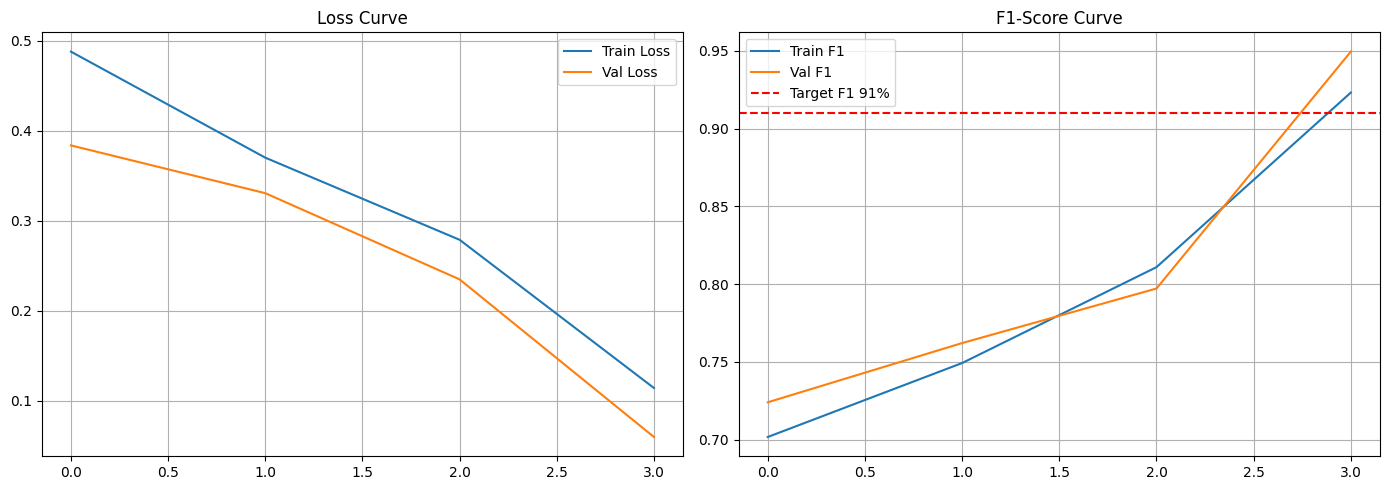

In [3]:
import torch
import torch.nn as nn
import timm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

print("="*80)
print("STEP 6: MODEL A - AUDIO SPECTROGRAM TRANSFORMER TRAINING")
print("="*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Define AST model adapted for one-channel input spectrograms
class ASTModel(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
        orig = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1, orig.out_channels,
            kernel_size=orig.kernel_size,
            stride=orig.stride,
            padding=orig.padding
        )
        with torch.no_grad():
            self.vit.patch_embed.proj.weight = nn.Parameter(orig.weight.mean(dim=1, keepdim=True))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((224,224))
    
    def forward(self, x):
        x = self.adaptive_pool(x)
        return self.vit(x)

model = ASTModel(num_classes=4, pretrained=True).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

EPOCHS = 50
EARLY_STOP_PATIENCE = 10

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0.0
epochs_no_improve = 0
best_model_path = 'model_a_best.pth'

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("="*30)
    
    # Training
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []
    train_loader = train_loader  # Presuming this is in your notebook session
    
    pbar = tqdm(train_loader, leave=False)
    for batch_specs, batch_labels in pbar:
        batch_specs = batch_specs.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_specs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())
        
        pbar.set_description(f"Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Validation
    model.eval()
    running_loss = 0
    val_preds = []
    val_labels = []
    val_loader = val_loader  # Presuming this is in your notebook session
    
    with torch.no_grad():
        for batch_specs, batch_labels in tqdm(val_loader, leave=False):
            batch_specs = batch_specs.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_specs)
            loss = criterion(outputs, batch_labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_labels.cpu().numpy())
    
    val_loss = running_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}% | Val   F1: {val_f1*100:.2f}%")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with F1: {val_f1*100:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No F1 improvement for {epochs_no_improve} epochs")
    
    if val_f1 >= 0.91:
        print("Target F1-score reached, stopping training early.")
        break
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print("Early stopping triggered.")
        break

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")
print(f"Best validation F1: {best_val_f1*100:.2f}%")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_f1'], label='Train F1')
axes[1].plot(history['val_f1'], label='Val F1')
axes[1].axhline(0.91, color='r', linestyle='--', label='Target F1 91%')
axes[1].set_title('F1-Score Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('model_a_training_history.png')
print("Training curves saved to 'model_a_training_history.png'")


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

# Load best model if starting a new session
model.load_state_dict(torch.load('model_a_best.pth'))

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for specs, labels in test_loader:
        specs = specs.to(device)
        outputs = model(specs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.numpy())

# Results summary
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Crackle', 'Wheeze', 'Both']))
print("Confusion matrix:")
print(confusion_matrix(test_labels, test_preds))


              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97      1957
     Crackle       0.90      0.96      0.93       293
      Wheeze       0.97      0.64      0.77       294
        Both       0.95      0.98      0.96       293

    accuracy                           0.95      2837
   macro avg       0.94      0.89      0.91      2837
weighted avg       0.95      0.95      0.94      2837

Confusion matrix:
[[1931   14    4    8]
 [   9  281    1    2]
 [  82   17  189    6]
 [   7    0    0  286]]


In [14]:
import numpy as np
data = np.load('preprocessed_data.npz', allow_pickle=True)
spectrograms = data['spectrograms']
disease_labels = data['disease_labels']


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model B initialized with 85,409,285 parameters
Class weights: [2.0437247  1.79007092 2.2893424  0.32950392 2.08164948]

Epoch 1/50


Train Loss: 1.4032 | Train Acc: 29.66% | Train F1: 32.78%
Val   Loss: 1.2555 | Val   Acc: 43.25% | Val   F1: 44.69%
Best model saved at epoch 1 with F1: 44.69%

Epoch 2/50


Train Loss: 1.3057 | Train Acc: 35.29% | Train F1: 39.52%
Val   Loss: 1.2311 | Val   Acc: 52.25% | Val   F1: 54.28%
Best model saved at epoch 2 with F1: 54.28%

Epoch 3/50


Train Loss: 1.2395 | Train Acc: 41.16% | Train F1: 45.33%
Val   Loss: 1.2067 | Val   Acc: 59.53% | Val   F1: 58.11%
Best model saved at epoch 3 with F1: 58.11%

Epoch 4/50


Train Loss: 1.1736 | Train Acc: 44.14% | Train F1: 48.18%
Val   Loss: 1.2032 | Val   Acc: 34.40% | Val   F1: 34.72%
No F1 improvement for 1 epochs

Epoch 5/50


Train Loss: 1.0589 | Train Acc: 47.93% | Train F1: 51.44%
Val   Loss: 1.0557 | Val   Acc: 61.80% | Val   F1: 61.93%
Best model saved at epoch 5 with F1: 61.93%

Epoch 6/50


Train Loss: 0.8575 | Train Acc: 57.09% | Train F1: 59.87%
Val   Loss: 0.9488 | Val   Acc: 51.37% | Val   F1: 54.56%
No F1 improvement for 1 epochs

Epoch 7/50


Train Loss: 0.6618 | Train Acc: 66.20% | Train F1: 68.15%
Val   Loss: 0.7888 | Val   Acc: 54.98% | Val   F1: 56.68%
No F1 improvement for 2 epochs

Epoch 8/50


Train Loss: 0.4819 | Train Acc: 76.27% | Train F1: 77.48%
Val   Loss: 0.7059 | Val   Acc: 72.69% | Val   F1: 74.28%
Best model saved at epoch 8 with F1: 74.28%

Epoch 9/50


Train Loss: 0.3287 | Train Acc: 84.25% | Train F1: 84.84%
Val   Loss: 0.5915 | Val   Acc: 78.81% | Val   F1: 79.69%
Best model saved at epoch 9 with F1: 79.69%

Epoch 10/50


Train Loss: 0.2307 | Train Acc: 89.59% | Train F1: 89.87%
Val   Loss: 0.5733 | Val   Acc: 79.65% | Val   F1: 80.83%
Best model saved at epoch 10 with F1: 80.83%

Epoch 11/50


Train Loss: 0.1513 | Train Acc: 93.93% | Train F1: 94.03%
Val   Loss: 0.5411 | Val   Acc: 90.03% | Val   F1: 89.99%
Best model saved at epoch 11 with F1: 89.99%

Epoch 12/50


Train Loss: 0.1004 | Train Acc: 96.41% | Train F1: 96.45%
Val   Loss: 0.5171 | Val   Acc: 88.73% | Val   F1: 89.01%
No F1 improvement for 1 epochs

Epoch 13/50


Train Loss: 0.0653 | Train Acc: 97.96% | Train F1: 97.97%
Val   Loss: 0.5692 | Val   Acc: 91.79% | Val   F1: 91.87%
Best model saved at epoch 13 with F1: 91.87%
Target F1-score reached, stopping training early.

Training completed in 42.82 minutes.
Best validation F1: 91.87%
Training curves saved to 'model_b_training_history.png'

Test set classification report:
              precision    recall  f1-score   support

      Normal       0.89      0.79      0.84       212
        COPD       0.94      0.98      0.96       241
      Asthma       0.86      0.80      0.83       189
   Pneumonia       0.95      0.94      0.94      1313
  Bronchitis       0.71      0.86      0.78       208

    accuracy                           0.91      2163
   macro avg       0.87      0.87      0.87      2163
weighted avg       0.91      0.91      0.91      2163

Confusion matrix:
[[ 167    4    3   24   14]
 [   4  235    0    1    1]
 [   1    4  152   26    6]
 [  11    4   17 1230   51]
 [   4    3    5

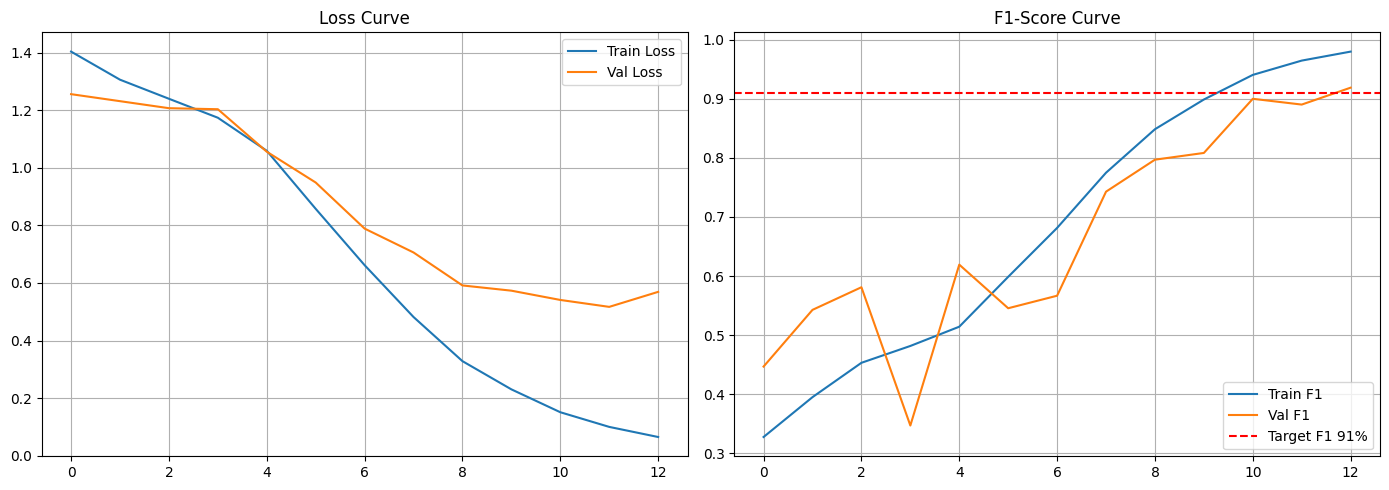

In [15]:
import numpy as np
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# 1. Use your preprocessed variables
spectrograms_final = spectrograms
disease_labels_final = disease_labels

# 2. Map disease labels to integers
disease_label_map = {
    'Normal': 0,
    'COPD': 1,
    'Asthma': 2,
    'Pneumonia': 3,
    'Bronchitis': 4
}
disease_labels_int = np.array([disease_label_map[label] for label in disease_labels_final])

# 3. Split data (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    spectrograms_final, disease_labels_int, test_size=0.15, stratify=disease_labels_int, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)

# 4. PyTorch Dataset and DataLoader
class DiseaseDataset(Dataset):
    def __init__(self, specs, labels):
        self.specs = specs
        self.labels = labels
    def __len__(self):
        return len(self.specs)
    def __getitem__(self, idx):
        spec = torch.FloatTensor(self.specs[idx]).unsqueeze(0)  # (1, 128, 157)
        label = int(self.labels[idx])
        return spec, label

batch_size = 32
train_dataset = DiseaseDataset(X_train, y_train)
val_dataset = DiseaseDataset(X_val, y_val)
test_dataset = DiseaseDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

# 5. AST Model Definition
class ASTModel(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
        orig = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1, orig.out_channels,
            kernel_size=orig.kernel_size,
            stride=orig.stride,
            padding=orig.padding
        )
        with torch.no_grad():
            self.vit.patch_embed.proj.weight = nn.Parameter(orig.weight.mean(dim=1, keepdim=True))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))
    def forward(self, x):
        x = self.adaptive_pool(x)
        return self.vit(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_b = ASTModel(num_classes=5).to(device)
print(f"Model B initialized with {sum(p.numel() for p in model_b.parameters()):,} parameters")

# 6. Loss, optimizer, scheduler
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model_b.parameters(), lr=5e-6, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 7. Training Loop
EPOCHS = 50
EARLY_STOP_PATIENCE = 10
best_val_f1 = 0.0
epochs_no_improve = 0
best_model_path = 'model_b_best.pth'
history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model_b.train()
    running_loss = 0
    all_preds = []
    all_labels = []
    for specs, labels in tqdm(train_loader, leave=False):
        specs, labels = specs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_b(specs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_b.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    model_b.eval()
    running_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for specs, labels in tqdm(val_loader, leave=False):
            specs, labels = specs.to(device), labels.to(device)
            outputs = model_b(specs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_loss = running_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}% | Val   F1: {val_f1*100:.2f}%")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model_b.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with F1: {val_f1*100:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No F1 improvement for {epochs_no_improve} epochs")

    if val_f1 >= 0.91:
        print("Target F1-score reached, stopping training early.")
        break
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print("Early stopping triggered.")
        break

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.2f} minutes.")
print(f"Best validation F1: {best_val_f1*100:.2f}%")

# 8. Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True)
axes[1].plot(history['train_f1'], label='Train F1')
axes[1].plot(history['val_f1'], label='Val F1')
axes[1].axhline(0.91, color='r', linestyle='--', label='Target F1 91%')
axes[1].set_title('F1-Score Curve')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.savefig('model_b_training_history.png')
print("Training curves saved to 'model_b_training_history.png'")

# 9. Test Evaluation
model_b.load_state_dict(torch.load(best_model_path))
model_b.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for specs, labels in test_loader:
        specs = specs.to(device)
        outputs = model_b(specs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.numpy())

print("\nTest set classification report:")
print(classification_report(test_labels, test_preds, target_names=list(disease_label_map.keys())))
print("Confusion matrix:")
print(confusion_matrix(test_labels, test_preds))


In [16]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Make sure you use the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_b.to(device)

# Load best weights (if you saved after training)
model_b.load_state_dict(torch.load('model_b_best.pth'))
model_b.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for specs, labels in test_loader:
        specs = specs.to(device)
        outputs = model_b(specs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.numpy())

# You can print metrics:
from sklearn.metrics import classification_report, confusion_matrix
disease_label_map = ['Normal', 'COPD', 'Asthma', 'Pneumonia', 'Bronchitis']

print(classification_report(test_labels, test_preds, target_names=disease_label_map))
print("Confusion matrix:")
print(confusion_matrix(test_labels, test_preds))


              precision    recall  f1-score   support

      Normal       0.89      0.79      0.84       212
        COPD       0.94      0.98      0.96       241
      Asthma       0.86      0.80      0.83       189
   Pneumonia       0.95      0.94      0.94      1313
  Bronchitis       0.71      0.86      0.78       208

    accuracy                           0.91      2163
   macro avg       0.87      0.87      0.87      2163
weighted avg       0.91      0.91      0.91      2163

Confusion matrix:
[[ 167    4    3   24   14]
 [   4  235    0    1    1]
 [   1    4  152   26    6]
 [  11    4   17 1230   51]
 [   4    3    5   18  178]]
